11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - classifier_accuracy: 0.6961 - decoder_accuracy: 0.0086 - loss: 1.0936 - val_classifier_accuracy: 0.9086 - val_decoder_accuracy: 0.0134 - val_loss: 0.4064
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - classifier_accuracy: 0.9039 - decoder_accuracy: 0.0097 - loss: 0.4189 - val_classifier_accuracy: 0.9183 - val_decoder_accuracy: 0.0094 - val_loss: 0.3601
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - classifier_accuracy: 0.9114 - decoder_accuracy: 0.0075 - loss: 0.3840 - val_classifier_accuracy: 0.9195 - val_decoder_accuracy: 0.0083 - val_loss: 0.3447
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - classifier_accuracy: 0.9130 - decoder_accuracy: 0.0078 - loss: 0.3627 - val_classifier_accuracy: 0.9235 - val_decoder_accuracy: 0.0095 - val_loss: 0.3340
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - classifier_accuracy: 0.9157 - decoder_accuracy: 0.0085 - 

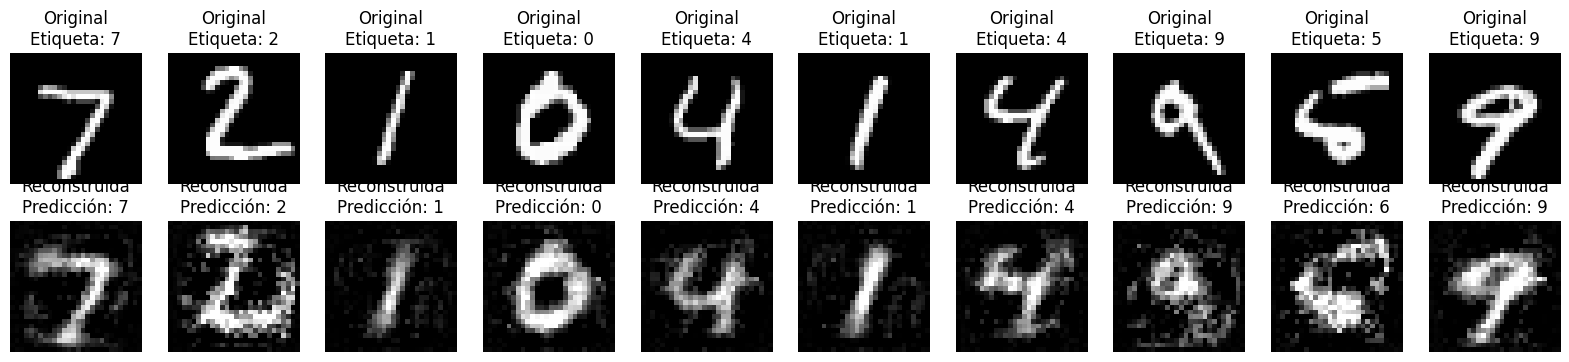

In [1]:
# Importando las bibliotecas necesarias para el procesamiento de datos y construcción de modelos
import matplotlib.pyplot as plt  # Biblioteca para generar gráficos y visualizaciones
import numpy as np  # Biblioteca para operaciones numéricas y manipulación de arreglos
import tensorflow as tf  # Biblioteca para construir y entrenar redes neuronales
from sklearn.metrics import mean_squared_error, f1_score  # Métricas de evaluación de modelos
from tensorflow.keras.datasets import mnist  # Conjunto de datos MNIST, comúnmente usado en tareas de reconocimiento de dígitos
from tensorflow.keras.utils import to_categorical  # Función para convertir etiquetas a formato one-hot encoding
from typing import Optional, Sequence  # Tipos de datos para parámetros opcionales y secuencias

# Definición de la función para visualizar las imágenes originales y las reconstruidas
def plot_mnist_autoencoder(
    x: Sequence[np.ndarray],  # Secuencia de imágenes originales (arreglos numpy)
    x_: Sequence[np.ndarray],  # Secuencia de imágenes reconstruidas (arreglos numpy)
    y: Optional[Sequence] = None,  # Etiquetas verdaderas de las imágenes (opcional)
    y_: Optional[Sequence] = None,  # Etiquetas predichas de las imágenes (opcional)
    cmap: str = 'gray',  # Mapa de colores para la visualización de las imágenes (por defecto es 'gray')
    vmin: float = 0,  # Valor mínimo para normalizar el mapa de colores
    vmax: float = 1  # Valor máximo para normalizar el mapa de colores
) -> None:
    """
    Esta función se utiliza para visualizar las imágenes originales y las imágenes reconstruidas
    utilizando un modelo autoencoder.

    Parámetros
    ----------
    x : Sequence[np.ndarray]
        Imágenes originales que se desean visualizar.
    x_ : Sequence[np.ndarray]
        Imágenes reconstruidas que se compararán con las originales.
    y : Optional[Sequence], opcional
        Etiquetas verdaderas de las imágenes, por defecto es None.
    y_ : Optional[Sequence], opcional
        Etiquetas predichas de las imágenes, por defecto es None.
    cmap : str, opcional
        Mapa de colores para las imágenes, por defecto es 'gray'.
    vmin : float, opcional
        Valor mínimo para la normalización del mapa de colores, por defecto es 0.
    vmax : float, opcional
        Valor máximo para la normalización del mapa de colores, por defecto es 1.
    """
    # Configuración de la figura y de las subtramas para visualizar las imágenes
    n = min(len(x), 10)  # Número de imágenes a visualizar (máximo 10)
    plt.figure(figsize=(20, 4))  # Tamaño de la figura

    for i in range(n):
        # Visualización de la imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x[i], cmap=cmap, vmin=vmin, vmax=vmax)
        plt.title(f"Original\nEtiqueta: {y[i]}" if y is not None else "Original")
        plt.axis("off")

        # Visualización de la imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_[i], cmap=cmap, vmin=vmin, vmax=vmax)
        plt.title(f"Reconstruida\nPredicción: {y_[i]}" if y_ is not None else "Reconstruida")
        plt.axis("off")

    plt.show()  # Mostrar la figura con las imágenes

# Cargando el conjunto de datos MNIST y preprocesando los datos
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0  # Aplanando y normalizando las imágenes de entrenamiento
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0  # Aplanando y normalizando las imágenes de prueba

y_train = to_categorical(y_train)  # Convertir etiquetas de entrenamiento a formato one-hot
y_test = to_categorical(y_test)  # Convertir etiquetas de prueba a formato one-hot

# Dividir el conjunto de entrenamiento para validación
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

# Definiendo el modelo PCA_Net
input_dim = x_train.shape[-1]  # Dimensión de entrada (784)
encoding_dim = 46  # Dimensión reducida para el encoder
num_classes = y_train.shape[-1]  # Número de clases (10)

# Capa de entrada
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(
            encoding_dim,
            use_bias=False,
            kernel_regularizer=tf.keras.regularizers.OrthogonalRegularizer(factor=0.1),
            activation="linear", name = 'encoder')

# Capa de decodificación atada a la capa de codificación
class DenseTied(tf.keras.layers.Layer):
    def __init__(self, tied_to, **kwargs):
        super().__init__(**kwargs)
        self.tied_to = tied_to

    def build(self, input_shape):
        self.kernel = self.tied_to.kernel

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel, transpose_b=True)

decoder = DenseTied(encoder, name = 'decoder')

# Capa de clasificación
classifier = tf.keras.layers.Dense(
            num_classes,
            activation="softmax", name = "classifier")

# Conectando las capas
encoded = encoder(input_layer)
decoded = decoder(encoded)
classification = classifier(encoded)

# Definiendo y compilando el modelo
model = tf.keras.Model(inputs=input_layer, outputs=[decoded, classification])
model.compile(optimizer='adam', loss=['mean_squared_error', 'categorical_crossentropy'], loss_weights = [0.5,1], metrics=["accuracy","accuracy"])

# Entrenamiento del modelo PCA_Net
history = model.fit(
    x_train, (x_train, y_train),  # Datos de entrenamiento y etiquetas
    epochs=50,  # Número de épocas
    batch_size=256,  # Tamaño del lote
    shuffle=True,  # Barajado de los datos de entrenamiento
    validation_data=(x_val, [x_val, y_val])
)

# Realizar predicciones con el modelo
x_pca, y_pca_pred = model.predict(x_test)

# Calcular el error cuadrático medio para la reconstrucción
mse_reconstruction = mean_squared_error(x_test.reshape(-1, input_dim), x_pca)

# Preparar las etiquetas verdaderas y predichas para calcular el F1 score
# Convertir etiquetas del formato categórico (one-hot) a formato de clase única
y_test_classes = np.argmax(y_test, axis=1)
y_pca_pred_classes = np.argmax(y_pca_pred, axis=1)

# Calcular el F1 score para la clasificación
f1 = f1_score(y_test_classes, y_pca_pred_classes, average='weighted')

print(f"Error Cuadrático Medio (Reconstrucción): {mse_reconstruction}")
print(f"Puntuación F1 (Clasificación): {f1}")

# Establecer el número de imágenes a mostrar
N = 20

plot_mnist_autoencoder(
    x_test[:N].reshape(-1, 28, 28),  # Remodelar las imágenes originales a (28, 28)
    x_pca[:N].reshape(-1, 28, 28),   # Remodelar las imágenes reconstruidas a (28, 28)
    y_test.argmax(axis=1)[:N],  # Etiquetas verdaderas de las primeras N imágenes
    y_pca_pred.argmax(axis=1)[:N]    # Etiquetas predichas de las primeras N imágenes
)
